In [1]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

## AGCRN Data

In [22]:
def sort_via_date(file_name):
    data = np.load(file_name)
    date = data['date']
    month = data['month']
    year = data['year']
    
    return year*10000 + month*100 + date

In [23]:
data = np.concatenate([np.load(e)['matrix'][:, :] for e in sorted(glob("assets/processed/matrix_short/*"), key=sort_via_date)], axis=-1)

In [24]:
output = []
mask = []
valid_ids = []
indices = np.arange(data[0].shape[0])
count = 0
for e in data:
    if not (e==0).all():
        output.append(np.interp(indices, indices[e!=0], e[e!=0]))
        output[-1][indices[e!=0]] = e[e!=0]
    else:
        output.append(e)
    
    mask.append(e!=0)

In [27]:
np.savez_compressed("../ETA/data/custom_agcrn", data=np.expand_dims(np.array(output).T, -1), mask=np.expand_dims(np.array(mask).T, axis=-1))

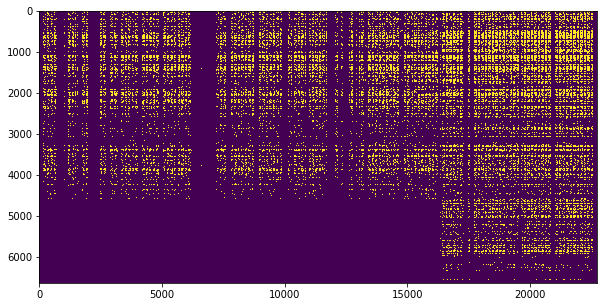

In [29]:
plt.figure(figsize=(10, 5))
plt.imshow(np.array(mask), aspect="auto")

## DCRNN data

In [30]:
direc = "../ETA/models/"

In [33]:
zip_obj = np.load("../ETA/data/custom_agcrn.npz")
dcrnn_data, dcrnn_mask = zip_obj['data'], zip_obj['mask']
time = np.tile(np.repeat(np.arange(144).reshape([1, -1])/144, 158, 0).reshape([144*158, 1, 1]), [1, 6639, 1])

In [34]:
dcrnn_data = np.concatenate([dcrnn_data, time], axis=-1)
dcrnn_mask = np.concatenate([dcrnn_mask, np.ones(dcrnn_mask.shape)], axis=-1)

In [35]:
dcrnn_data.shape

(22752, 6639, 2)

In [43]:
x, y = [], []
num_samples, num_nodes = dcrnn_data.shape[:2]

x_offsets = np.sort(np.concatenate((np.arange(-5, 1, 1),)))
y_offsets = np.sort(np.arange(1, 7, 1))

min_t = abs(min(x_offsets))
max_t = abs(num_samples - abs(max(y_offsets)))

train_count = 0
test_count = 0
val_count = 0

samples = np.zeros(max_t - min_t)
samples[np.random.randint(max_t - min_t, size=int(0.2*len(samples)))] = 1 
samples[np.random.randint(max_t - min_t, size=int(0.2*len(samples)))] = 2 

for t in tqdm(range(min_t, max_t)):
    x_t = dcrnn_data[t + x_offsets, ...]
    y_t = dcrnn_data[t + y_offsets, ...] * dcrnn_mask[t + y_offsets, ...]
    

    if samples[t-min_t] == 0:
        folder = "../ETA/models/ETA/data/training_files/custom_{}/{}".format("train", train_count)
        train_count += 1
    elif samples[t-min_t] == 1:
        folder = "../ETA/models/ETA/data/training_files/custom_{}/{}".format("val", train_count)
        val_count += 1
    else:
        folder = "../ETA/models/ETA/data/training_files/custom_{}/{}".format("test", train_count)
        test_count += 1
    
    np.savez_compressed(folder,
                        x = x_t,
                        y = y_t)
    

In [11]:
stuff = glob("../ETA/models/ETA/data/training_files/custom_*/*.npz")

In [13]:
shapes = []
for e in tqdm(stuff):
    shapes += np.load(stuff[0])['x'].shape
    shapes += np.load(stuff[0])['y'].shape

In [14]:
len(stuff)

21266

In [15]:
shape

127596

In [84]:
num_samples = len(x)
num_test = round(num_samples * 0.2)
num_train = round(num_samples * 0.7)
num_val = num_samples - num_test - num_train

# train
x_train, y_train = x[:num_train], y[:num_train]
# val
x_val, y_val = (
    x[num_train: num_train + num_val],
    y[num_train: num_train + num_val],
)
# test
x_test, y_test = x[-num_test:], y[-num_test:]

for cat in ["train", "val", "test"]:
    _x, _y = locals()["x_" + cat], locals()["y_" + cat]
    np.savez_compressed(
        "../ETA/data/custom_{}".format(cat),
        x=_x,
        y=_y,
        x_offsets=x_offsets.reshape(list(x_offsets.shape) + [1]),
        y_offsets=y_offsets.reshape(list(y_offsets.shape) + [1]),
    )

In [18]:
np.count_nonzero(y), np.count_nonzero(x)

(108586202, 453921641)

In [3]:
mkdir ../ETA/DCRNN/data/custom_val

In [7]:
for e in ["train", "val", "test"]:
    data = np.load("../ETA/data/custom_{}.npz".format(e))
    x_d = data['x']
    y_d = data['y']
    
    for i in tqdm(range(len(x_d))):
        np.savez_compressed("../ETA/data/custom_{}/{}".format(e, i),
                            x = x_d[i],
                            y = y_d[i])

In [10]:
ls -lah ../ETA/data

total 1.3G
drwxrwxr-x 5 pravesh pravesh 4.0K Dec 16 04:02 ./
drwxrwxr-x 4 pravesh pravesh 4.0K Dec 16 04:01 ../
drwxrwxr-x 2 pravesh pravesh  36K Dec  9 21:22 custom_test/
-rw-rw-r-- 1 pravesh pravesh 251M Dec 22 12:57 custom_test.npz
drwxrwxr-x 2 pravesh pravesh 112K Dec 25 12:14 custom_train/
-rw-rw-r-- 1 pravesh pravesh 915M Dec 22 12:56 custom_train.npz
drwxrwxr-x 2 pravesh pravesh  20K Dec  9 21:22 custom_val/
-rw-rw-r-- 1 pravesh pravesh 129M Dec 22 12:56 custom_val.npz
